In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
import pywt
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score

import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.utils import resample

import os
from keras.models import Sequential
from keras.layers import Convolution1D, Flatten, Dense, Dropout, Softmax,MaxPooling1D, AveragePooling1D
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.utils import plot_model
from keras import regularizers
from tensorflow.keras.layers import BatchNormalization

In [2]:
plt.rcParams["figure.figsize"] = (10,6)

In [3]:
classes = ['N', 'L', 'R', 'A', 'V']
n_classes = len(classes)
count_classes = [0]*n_classes
count_classes

[0, 0, 0, 0, 0]

In [4]:
path = r"C:\Users\shank\OneDrive\Desktop\New folder\archive\mitbih_database"
filenames = next(os.walk(path))[2]
records=list()
annotations=list()
filenames.sort()

In [5]:
for f in filenames:
    filename, file_extension = os.path.splitext(f)

    if(file_extension=='.csv'):
        records.append(path+'/'+filename+file_extension)
    else:
        annotations.append(path+'/'+filename+file_extension)

records[0]

'C:\\Users\\shank\\OneDrive\\Desktop\\New folder\\archive\\mitbih_database/100.csv'

In [6]:
temp_signal=[]
with open(records[6],'r') as csvfile:
    filereader = csv.reader(csvfile,delimiter=',',quotechar='|')
    row_index = -1
    for row in filereader:
        if(row_index >= 0):
            temp_signal.insert(row_index, int(row[1]))
        row_index += 1

In [7]:
temp_signal[0:10]

[962, 962, 962, 962, 962, 962, 962, 962, 966, 967]

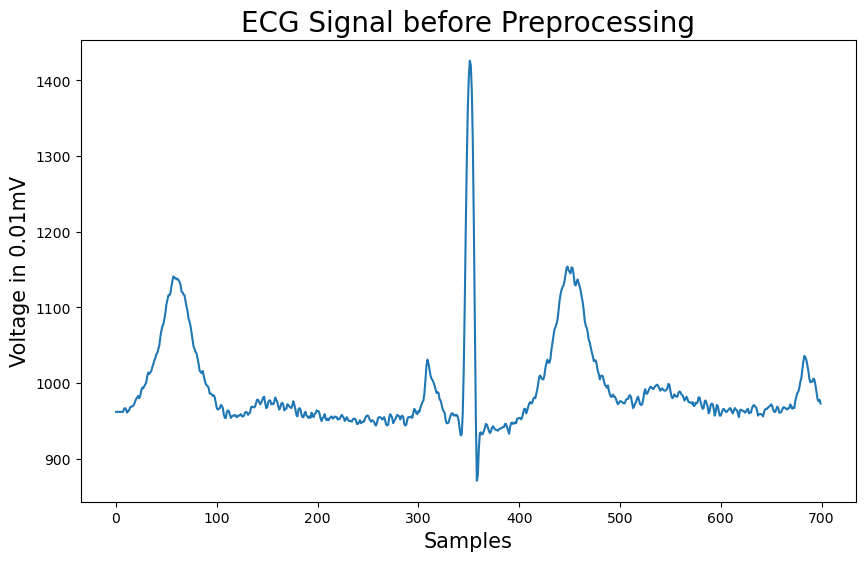

In [8]:
plt.plot(temp_signal[0:700])
plt.title('ECG Signal before Preprocessing',fontsize=20)
plt.xlabel('Samples', fontsize=15)
plt.ylabel('Voltage in 0.01mV',fontsize=15)
plt.savefig('before_preprocessing')

In [9]:
temp2signal=temp_signal

In [10]:
def denoise(data):
    w = pywt.Wavelet('sym4')
    maxlev = pywt.dwt_max_level(len(data), w.dec_len)
    threshold = 0.04 # Threshold for filtering

    coeffs = pywt.wavedec(data, 'sym4', level=maxlev)
  #  print(len(coeffs))
    for i in range(1, len(coeffs)):
        coeffs[i] = pywt.threshold(coeffs[i], threshold*max(coeffs[i]))

    datarec = pywt.waverec(coeffs, 'sym4')
    return datarec

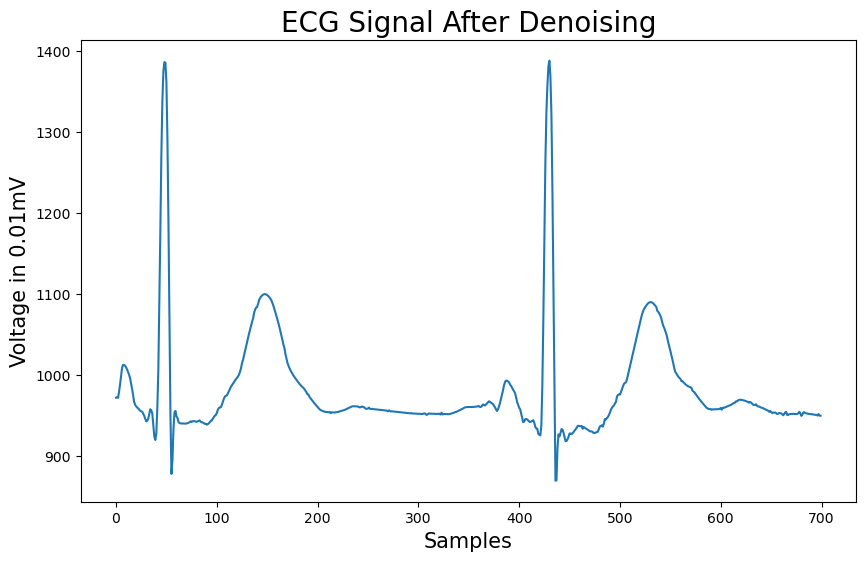

In [11]:
temp_signal=denoise(temp_signal)
plt.plot(temp_signal[1400:2100])
plt.title('ECG Signal After Denoising',fontsize=20)
plt.xlabel('Samples', fontsize=15)
plt.ylabel('Voltage in 0.01mV', fontsize=15)
plt.savefig('after_denoising')

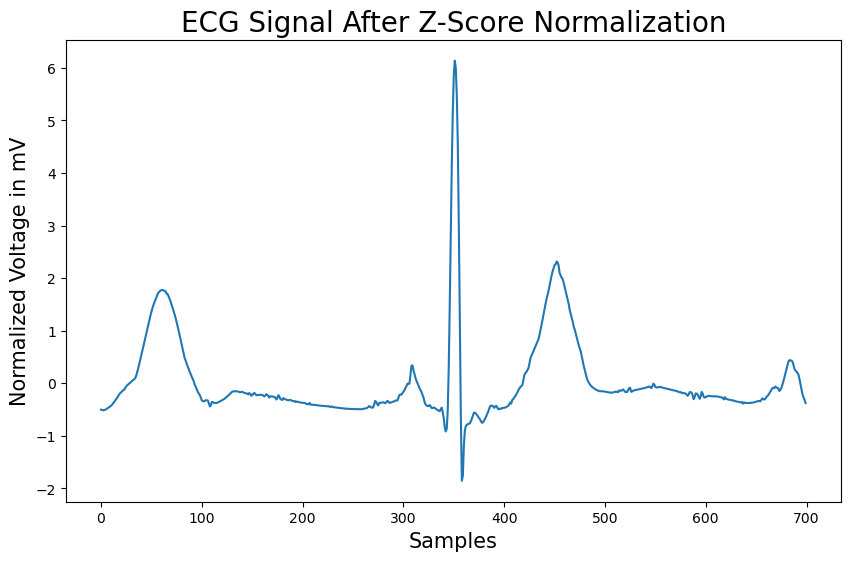

In [12]:
temp_signal = stats.zscore(temp_signal)
plt.plot(temp_signal[:700])
plt.title('ECG Signal After Z-Score Normalization',fontsize=20)
plt.xlabel('Samples',fontsize=15)
plt.ylabel('Normalized Voltage in mV',fontsize=15)
plt.savefig('after_norm')

In [13]:
X=list()
y=list()
window_size=180
for r in range(0,len(records)):
    signals = []

    with open(records[r], 'r') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',', quotechar='|') 
        row_index = -1
        for row in spamreader:
            if(row_index >= 0):
                signals.insert(row_index, int(row[1]))
            row_index += 1

        
    signals = denoise(signals)
    #signals = signals.reshape(-1,1)
    signals = stats.zscore(signals)

    with open(annotations[r], 'r') as fileID:
        data = fileID.readlines() 
        beat = list()

        for d in range(1, len(data)): 
            splitted = data[d].split(' ') 
            splitted = filter(None, splitted)
            next(splitted) 
            pos = int(next(splitted)) 
            arrhythmia_type = next(splitted) 
            
            if(arrhythmia_type in classes):
                arrhythmia_index = classes.index(arrhythmia_type)
                count_classes[arrhythmia_index] += 1
                if(window_size <= pos and pos < (len(signals) - window_size)):  
                    beat = signals[pos-window_size:pos+window_size]   

                    X.append(beat)
                    y.append(arrhythmia_index)

# data shape
print(np.shape(X), np.shape(y))

(100012, 360) (100012,)


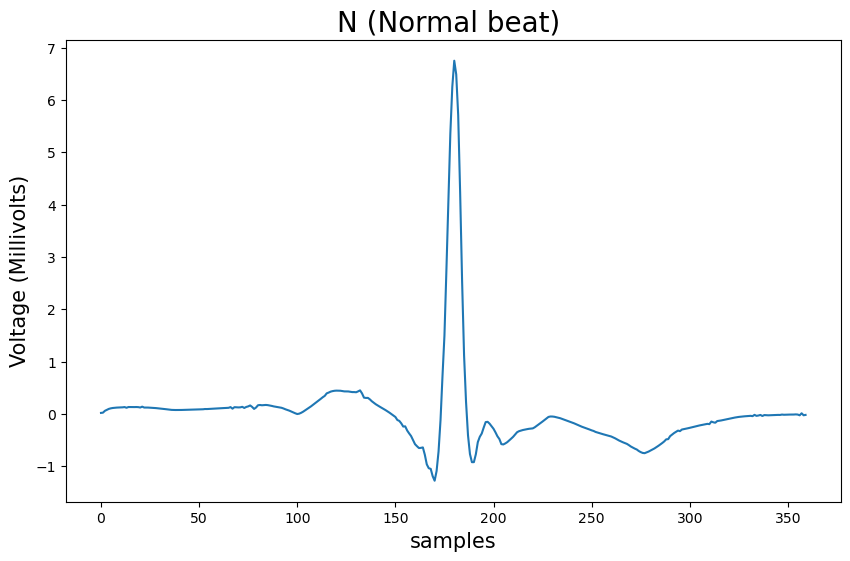

In [14]:
i=0;
while y[i]!=0:
    i=i+1

plt.plot(X[i])
plt.title('N (Normal beat) ', fontsize=20)
plt.xlabel('samples',fontsize=15);
plt.ylabel('Voltage (Millivolts)',fontsize=15)
plt.savefig('N')

0
0    75011
1     8071
2     7255
4     7129
3     2546
Name: count, dtype: int64


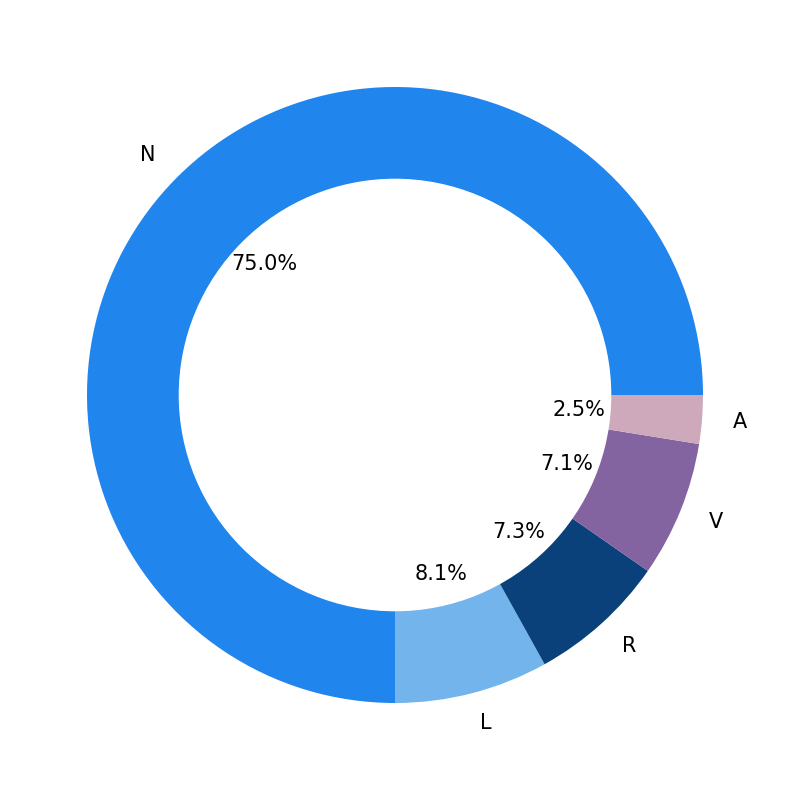

In [15]:
y_df = pd.DataFrame(y)
y_df.head()
per_class = y_df[y_df.shape[1]-1].value_counts()
print(per_class)
plt.figure(figsize=(30,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(per_class, labels=['N', 'L', 'R', 'V', 'A'], colors=['#2085ec','#72b4eb','#0a417a','#8464a0','#cea9bc'],autopct='%1.1f%%', textprops={'fontsize':15})
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()
p.savefig('Before_piechart')

In [16]:
X = np.array(X)
X_reshaped = X.reshape(-1,360,)
X_reshaped.shape

(100012, 360)

In [17]:
X_df = pd.DataFrame(X_reshaped)
X_df.head()

,0,1,2,3,4,5,6,7,8,9,...,350,351,352,353,354,355,356,357,358,359
0,0.018228,0.022953,0.058424,0.077107,0.095080,0.105492,0.112325,0.116982,0.119703,0.122254,...,-0.014193,-0.013640,-0.013518,-0.012969,-0.010249,-0.013186,-0.027581,0.010994,-0.026885,-0.020095
1,-0.366827,-0.344524,-0.320039,-0.330324,-0.299629,-0.292238,-0.283900,-0.275759,-0.267345,-0.257942,...,-0.140757,-0.140611,-0.140669,-0.140735,-0.141352,-0.140082,-0.136719,-0.144822,-0.139946,-0.142478
2,-0.171359,-0.140344,-0.109854,-0.078079,-0.048978,-0.034990,-0.028194,-0.024550,-0.024222,-0.023859,...,-0.005353,0.001325,0.007875,0.015828,0.025088,0.030657,0.026670,0.056487,0.028112,0.028259
3,-0.186526,-0.182575,-0.177326,-0.171800,-0.165320,-0.158725,-0.151677,-0.144942,-0.140875,-0.138009,...,0.014056,0.021386,0.032036,0.043188,0.058269,0.074966,0.076706,0.073569,0.093104,0.116388
4,-0.369240,-0.368380,-0.344557,-0.314211,-0.295571,-0.279271,-0.261415,-0.243202,-0.221928,-0.200658,...,-0.024847,-0.019342,-0.014265,-0.009238,-0.004046,0.001153,0.006449,0.011785,0.016524,0.021073


In [18]:
X_new_df = pd.concat([X_df,y_df],axis=1)
X_new_df.head()

,0,1,2,3,4,5,6,7,8,9,...,351,352,353,354,355,356,357,358,359,0
0,0.018228,0.022953,0.058424,0.077107,0.095080,0.105492,0.112325,0.116982,0.119703,0.122254,...,-0.013640,-0.013518,-0.012969,-0.010249,-0.013186,-0.027581,0.010994,-0.026885,-0.020095,0
1,-0.366827,-0.344524,-0.320039,-0.330324,-0.299629,-0.292238,-0.283900,-0.275759,-0.267345,-0.257942,...,-0.140611,-0.140669,-0.140735,-0.141352,-0.140082,-0.136719,-0.144822,-0.139946,-0.142478,0
2,-0.171359,-0.140344,-0.109854,-0.078079,-0.048978,-0.034990,-0.028194,-0.024550,-0.024222,-0.023859,...,0.001325,0.007875,0.015828,0.025088,0.030657,0.026670,0.056487,0.028112,0.028259,0
3,-0.186526,-0.182575,-0.177326,-0.171800,-0.165320,-0.158725,-0.151677,-0.144942,-0.140875,-0.138009,...,0.021386,0.032036,0.043188,0.058269,0.074966,0.076706,0.073569,0.093104,0.116388,0
4,-0.369240,-0.368380,-0.344557,-0.314211,-0.295571,-0.279271,-0.261415,-0.243202,-0.221928,-0.200658,...,-0.019342,-0.014265,-0.009238,-0.004046,0.001153,0.006449,0.011785,0.016524,0.021073,0


In [19]:
ax=list(range(361))
X_new_df = X_new_df.set_axis(ax, axis='columns')

In [20]:
df_0=(X_new_df[X_new_df[X_new_df.shape[1]-1]==0]).sample(n=10000,random_state=42)
df_1=X_new_df[X_new_df[X_new_df.shape[1]-1]==1]
df_2=X_new_df[X_new_df[X_new_df.shape[1]-1]==2]
df_3=X_new_df[X_new_df[X_new_df.shape[1]-1]==3]
df_4=X_new_df[X_new_df[X_new_df.shape[1]-1]==4]

df_1_upsample=resample(df_1,replace=True,n_samples=7000,random_state=122)
df_2_upsample=resample(df_2,replace=True,n_samples=7000,random_state=123)
df_3_upsample=resample(df_3,replace=True,n_samples=5000,random_state=125)
df_4_upsample=resample(df_4,replace=True,n_samples=7000,random_state=125)

X_new_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample])

360
0    10000
1     7000
2     7000
4     7000
3     5000
Name: count, dtype: int64


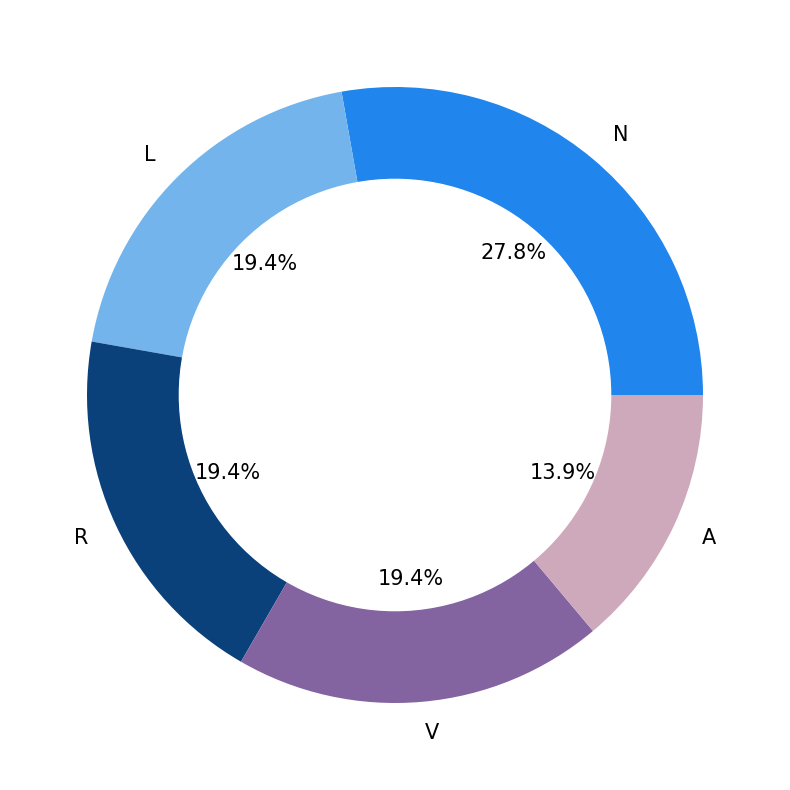

In [21]:
per_class = X_new_df[X_new_df.shape[1]-1].value_counts()
print(per_class)
plt.figure(figsize=(30,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(per_class, labels=['N', 'L', 'R', 'V', 'A'], colors=['#2085ec','#72b4eb','#0a417a','#8464a0','#cea9bc'],autopct='%1.1f%%',textprops={'fontsize':15})
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()
p.savefig('after_piechart')

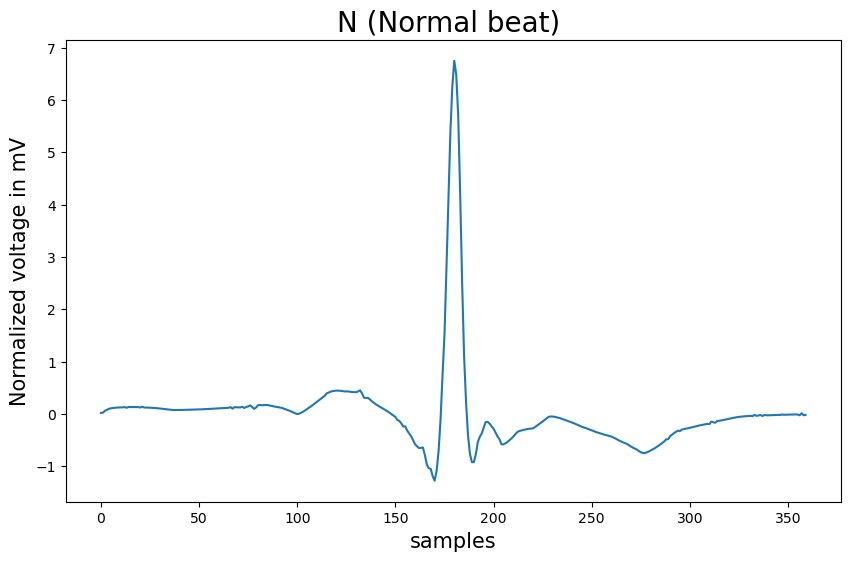

In [22]:
i=0;
while y[i]!=0:
    i=i+1

plt.plot(X[i])
plt.title('N (Normal beat) ', fontsize=20)
plt.xlabel('samples',fontsize=15);
plt.ylabel('Normalized voltage in mV',fontsize=15)
plt.savefig('N')

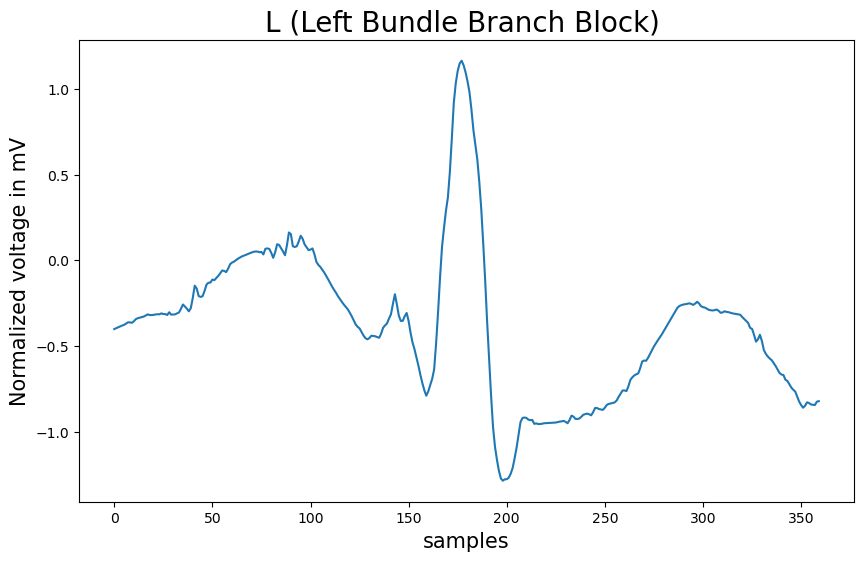

In [23]:
i=0;
while y[i]!=1:
    i=i+1

plt.plot(X[i])
plt.title('L (Left Bundle Branch Block) ', fontsize=20)
plt.xlabel('samples',fontsize=15);
plt.ylabel('Normalized voltage in mV',fontsize=15)
plt.savefig('L')

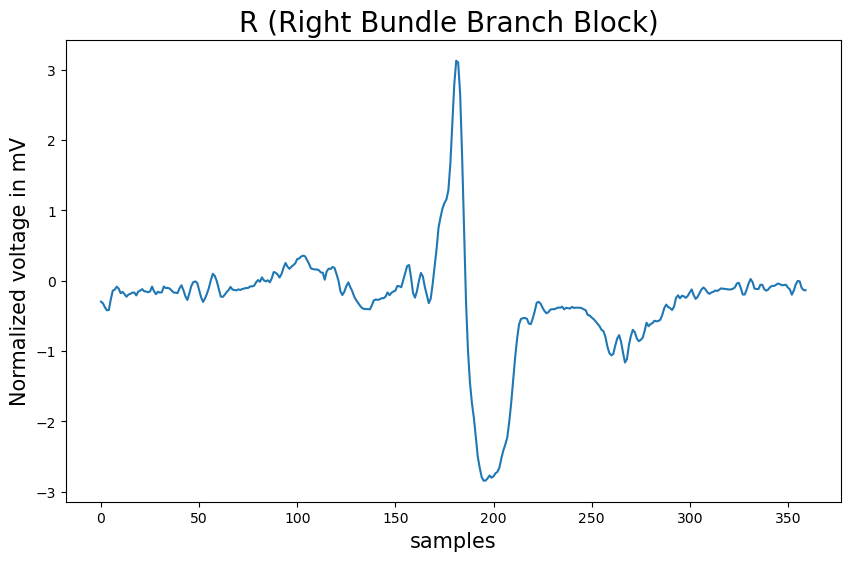

In [24]:
i=0;
while y[i]!=2:
    i=i+1

plt.plot(X[i])
plt.title('R (Right Bundle Branch Block) ', fontsize=20)
plt.xlabel('samples',fontsize=15);
plt.ylabel('Normalized voltage in mV',fontsize=15)
plt.savefig('R')

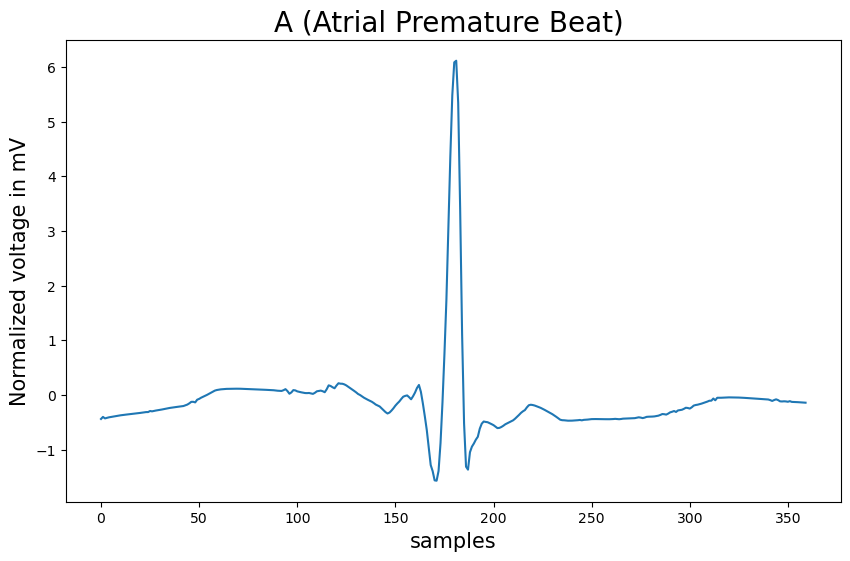

In [25]:
i=0;
while y[i]!=3:
    i=i+1

plt.plot(X[i])
plt.title('A (Atrial Premature Beat) ', fontsize=20)
plt.xlabel('samples',fontsize=15);
plt.ylabel('Normalized voltage in mV',fontsize=15)
plt.savefig('A')

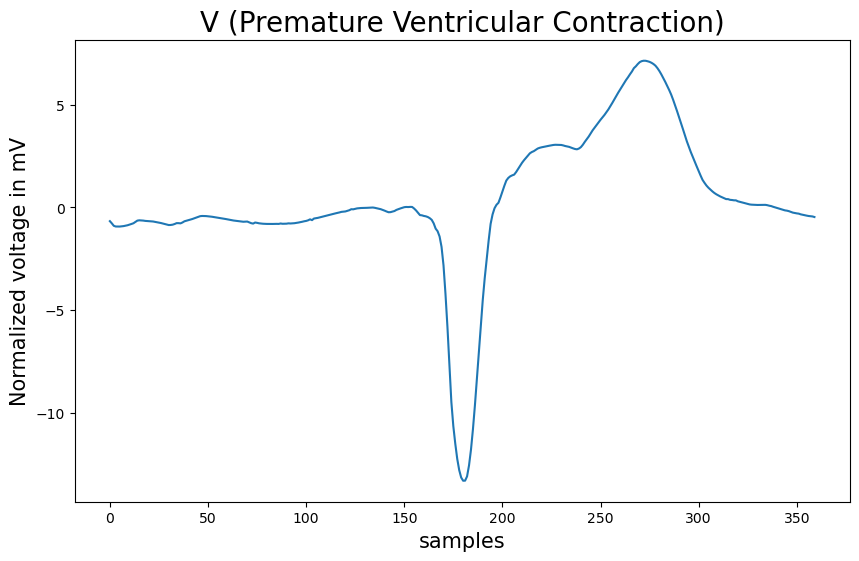

In [26]:
i=0;
while y[i]!=4:
    i=i+1

plt.plot(X[i])
plt.title('V (Premature Ventricular Contraction)', fontsize=20)
plt.xlabel('samples',fontsize=15);
plt.ylabel('Normalized voltage in mV',fontsize=15)
plt.savefig('V')

In [27]:
train, test = train_test_split(X_new_df, test_size=0.20, random_state=7)

print("X_train : ", np.shape(train))
print("X_test  : ", np.shape(test))

X_train :  (28800, 361)
X_test  :  (7200, 361)


In [28]:
target_train=train[train.shape[1]-1]
target_test=test[test.shape[1]-1]
y_train=to_categorical(target_train)
y_test=to_categorical(target_test)
print(np.shape(y_train), np.shape(y_test))

(28800, 5) (7200, 5)


In [29]:
X_train = train.iloc[:,:train.shape[1]-1].values
X_test = test.iloc[:,:test.shape[1]-1].values
X_train = X_train.reshape(len(X_train), X_train.shape[1],1)
X_test = X_test.reshape(len(X_test), X_test.shape[1],1)
print(np.shape(X_train), np.shape(X_test))

(28800, 360, 1) (7200, 360, 1)


In [30]:
model = Sequential()

model.add(Convolution1D(filters=16, kernel_size=7, strides=1, padding='same' , activation = 'relu', input_shape=(360,1)))
model.add(MaxPooling1D(pool_size=3, strides=2))

model.add(Convolution1D(filters=32, kernel_size=9, strides=1, padding='same' , activation = 'relu'))
model.add(MaxPooling1D(pool_size=3, strides=2))

model.add(Convolution1D(filters=64, kernel_size=11, strides=1, padding='same' , activation = 'relu'))
model.add(MaxPooling1D(pool_size=3, strides=2))

model.add(Convolution1D(filters=128, kernel_size=13, strides=1, padding='same' , activation = 'relu'))
model.add(MaxPooling1D(pool_size=3, strides=2))

model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(100, activation='relu'))

model.add(Dense(50, activation='relu'))

model.add(Dense(5, activation='softmax'))
model.summary()

C:\Users\shank\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 360, 16)             │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 179, 16)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 179, 32)             │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 89, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 89, 64)              │          22,592 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 44, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 44, 128)             │         106,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, 21, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2688)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2688)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 100)                 │         268,900 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 50)                  │           5,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 5)                   │             255 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 408,189 (1.56 MB)

 Trainable params: 408,189 (1.56 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [32]:
history = model.fit(X_train, y_train, batch_size=30, epochs=5, verbose=1, validation_data=(X_test, y_test))

Epoch 1/5
960/960 ━━━━━━━━━━━━━━━━━━━━ 34s 25ms/step - accuracy: 0.8380 - loss: 0.4556 - val_accuracy: 0.9678 - val_loss: 0.0974
Epoch 2/5
960/960 ━━━━━━━━━━━━━━━━━━━━ 24s 25ms/step - accuracy: 0.9671 - loss: 0.1012 - val_accuracy: 0.9743 - val_loss: 0.0770
Epoch 3/5
960/960 ━━━━━━━━━━━━━━━━━━━━ 24s 25ms/step - accuracy: 0.9767 - loss: 0.0725 - val_accuracy: 0.9710 - val_loss: 0.0931
Epoch 4/5
960/960 ━━━━━━━━━━━━━━━━━━━━ 24s 25ms/step - accuracy: 0.9800 - loss: 0.0620 - val_accuracy: 0.9876 - val_loss: 0.0400
Epoch 5/5
960/960 ━━━━━━━━━━━━━━━━━━━━ 24s 24ms/step - accuracy: 0.9853 - loss: 0.0457 - val_accuracy: 0.9754 - val_loss: 0.0757


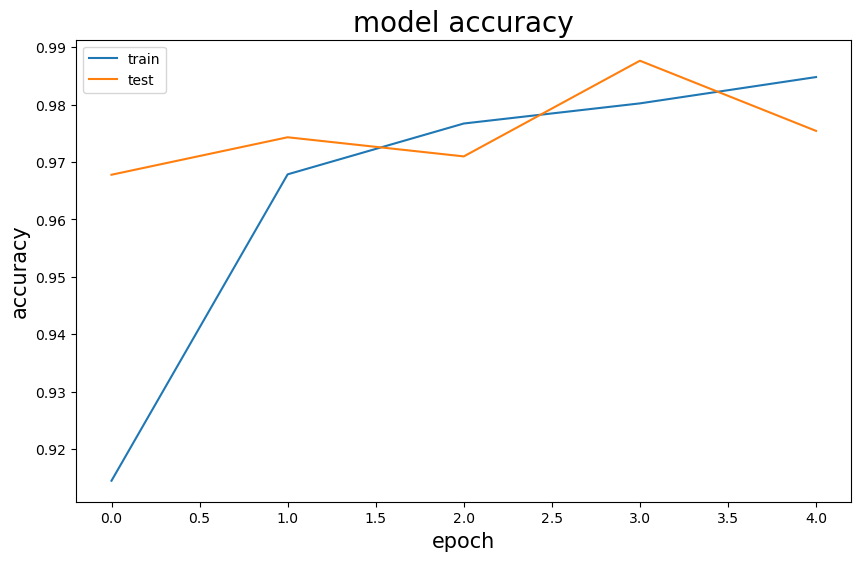

In [33]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy',fontsize=20)
plt.ylabel('accuracy',fontsize=15)
plt.xlabel('epoch',fontsize=15)
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('accuracy_plot')
plt.show()

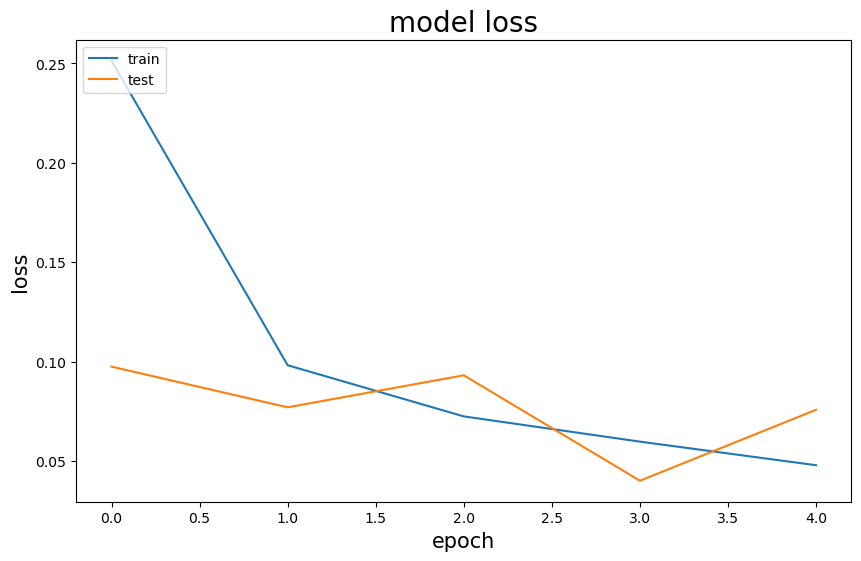

In [34]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss', fontsize=20)
plt.ylabel('loss', fontsize=15)
plt.xlabel('epoch', fontsize=15)
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('loss_plot')
plt.show()

In [35]:
score = model.evaluate(X_test, y_test)

print('Test Loss:', score[0])
print('Test accuracy:', score[1])

225/225 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.9775 - loss: 0.0707
Test Loss: 0.07571117579936981
Test accuracy: 0.9754166603088379


225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step


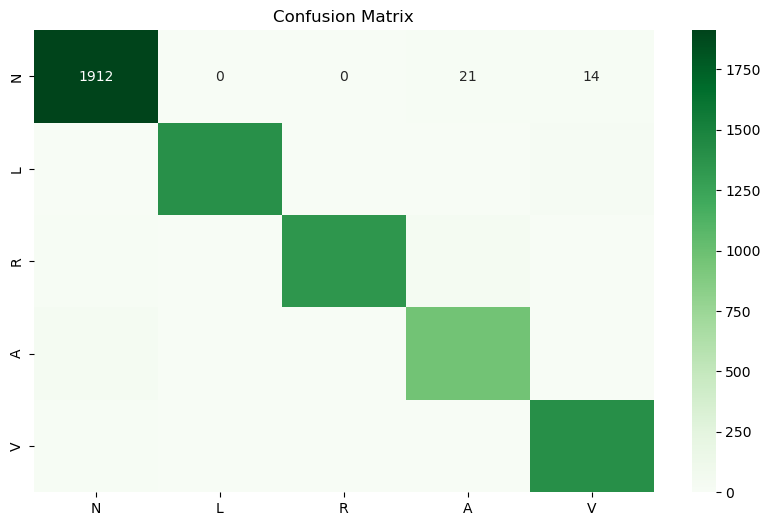

In [36]:
y_true=[]
for element in y_test:
    y_true.append(np.argmax(element))
prediction_proba=model.predict(X_test)
prediction=np.argmax(prediction_proba,axis=1)
ax=plt.subplot()
custCnnConfMat = confusion_matrix(y_true, prediction)
sns.heatmap(custCnnConfMat, annot=True,fmt='d', cmap='Greens',ax=ax)
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(classes); ax.yaxis.set_ticklabels(classes);
plt.savefig('cm')

In [37]:
from sklearn.metrics import classification_report

cf = classification_report(y_true, prediction, target_names=classes,digits=4)
print(cf)

              precision    recall  f1-score   support

           N     0.9671    0.9820    0.9745      1947
           L     0.9993    0.9810    0.9901      1423
           R     1.0000    0.9595    0.9793      1407
           A     0.9343    0.9574    0.9457      1010
           V     0.9702    0.9894    0.9797      1413

    accuracy                         0.9754      7200
   macro avg     0.9742    0.9739    0.9739      7200
weighted avg     0.9759    0.9754    0.9755      7200



In [38]:
import numpy as np
import random

# Assuming X_test is your test data and y_test are the corresponding labels
num_samples_to_predict = 10  # Number of samples to predict

# Randomly select samples from X_test and y_test
sample_indices = random.sample(range(len(X_test)), num_samples_to_predict)
sample_images = X_test[sample_indices]
sample_labels = y_test[sample_indices]

# Predict classes
predictions = model.predict(sample_images)
predicted_classes = np.argmax(predictions, axis=1)

# Display predictions
for i in range(num_samples_to_predict):
    print(f"Sample {i+1}: Predicted class: {predicted_classes[i]}, Actual class: {np.argmax(sample_labels[i])}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step
Sample 1: Predicted class: 0, Actual class: 0
Sample 2: Predicted class: 3, Actual class: 3
Sample 3: Predicted class: 2, Actual class: 2
Sample 4: Predicted class: 0, Actual class: 0
Sample 5: Predicted class: 2, Actual class: 2
Sample 6: Predicted class: 4, Actual class: 4
Sample 7: Predicted class: 2, Actual class: 2
Sample 8: Predicted class: 1, Actual class: 1
Sample 9: Predicted class: 1, Actual class: 1
Sample 10: Predicted class: 2, Actual class: 2
